Source:
https://www.ncei.noaa.gov/pub/data/ghcn/daily/

Menne, M.J., I. Durre, B. Korzeniewski, S. McNeill, K. Thomas, X. Yin, S. Anthony, R. Ray,
R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network -
Daily (GHCN-Daily), Version 3. [indicate subset used following decimal,
e.g. Version 3.12].
NOAA National Climatic Data Center. http://doi.org/10.7289/V5D21VHZ [1/3/26].


In [31]:
import tarfile
import time
import pandas as pd
import numpy as np

def parse_dly_to_monthly(file_obj):
    # Keys are (year, month)
    # Sums and counts stores separately
    sums = {}
    counts = {}

    for raw in file_obj:
        line = raw.decode("utf-8")
        station = line[0:11]
        year = int(line[11:15])
        month = int(line[15:17])
        element = line[17:21]

        if element not in ("TMAX", "TMIN", "PRCP"):
            continue

        key = (station, year, month)
        if key not in sums:
            sums[key] = {"TMAX": 0, "TMIN": 0, "PRCP": 0}
            counts[key] = {"TMAX": 0, "TMIN": 0, "PRCP": 0}

        # 31 day slots, each 8 chars: VALUE(5) MFLAG(1) QFLAG(1) SFLAG(1)
        for d in range(31):
            i = 21 + d * 8
            v = int(line[i:i+5])
            qflag = line[i+6]

            if v == -9999:
                continue
            if qflag != " ":  # keep only unflagged values
                continue

            sums[key][element] += v
            counts[key][element] += 1

    if not sums:
        return pd.DataFrame(columns=[
            "station_id","year","month","tmax_mean","tmin_mean","prcp_sum","n_tmax","n_tmin","n_prcp"
        ])

    out = []
    for (station, year, month), s in sums.items():
        c = counts[(station, year, month)]
        out.append({
            "station_id": station,
            "year": year,
            "month": month,
            "tmax_mean": (s["TMAX"] / c["TMAX"]) if c["TMAX"] else np.nan,
            "tmin_mean": (s["TMIN"] / c["TMIN"]) if c["TMIN"] else np.nan,
            "prcp_sum":  s["PRCP"] if c["PRCP"] else np.nan,
            "n_tmax": c["TMAX"],
            "n_tmin": c["TMIN"],
            "n_prcp": c["PRCP"],
        })

    return pd.DataFrame(out)

monthly_parts = []
t0 = time.time()
n_files = 0

with tarfile.open("data/ghcnd_hcn.tar.gz", "r:gz") as tar:
    for member in tar.getmembers():
        if member.isfile() and member.name.endswith(".dly"):
            f = tar.extractfile(member)
            if f is None:
                continue

            df_m = parse_dly_to_monthly(f)
            monthly_parts.append(df_m)

            n_files += 1
            if n_files % 50 == 0:
                print(f"{n_files} station files processed | elapsed {time.time()-t0:.1f}s")

monthly_station = pd.concat(monthly_parts, ignore_index=True)


50 station files processed | elapsed 17.2s
100 station files processed | elapsed 25.0s
150 station files processed | elapsed 34.4s
200 station files processed | elapsed 41.2s
250 station files processed | elapsed 53.5s
300 station files processed | elapsed 63.7s
350 station files processed | elapsed 70.7s
400 station files processed | elapsed 78.4s
450 station files processed | elapsed 89.0s
500 station files processed | elapsed 97.2s
550 station files processed | elapsed 105.1s
600 station files processed | elapsed 111.8s
650 station files processed | elapsed 118.2s
700 station files processed | elapsed 124.1s
750 station files processed | elapsed 130.3s
800 station files processed | elapsed 139.4s
850 station files processed | elapsed 154.8s
900 station files processed | elapsed 162.0s
950 station files processed | elapsed 170.3s
1000 station files processed | elapsed 185.9s
1050 station files processed | elapsed 193.7s
1100 station files processed | elapsed 200.4s
1150 station files

In [12]:
monthly_station.head()

,station_id,year,month,tmax_mean,tmin_mean,prcp,n_tmax,n_tmin,n_prcp,avg_temp
0,USC00035820,1871,7,33.293548,22.822581,NaN,31,31,0,28.058065
1,USC00035820,1871,10,22.590000,6.870000,0.0,20,20,20,14.730000
2,USC00035820,1871,11,14.556667,0.700000,66.0,30,30,30,7.628333
3,USC00035820,1871,12,5.853333,-4.861290,51.0,30,31,31,0.496022
4,USC00035820,1872,1,4.812903,-5.167742,85.1,31,31,31,-0.177419


In [32]:
# Converting from tenth units to real
monthly_station["tmax_mean"] = monthly_station["tmax_mean"] / 10.0
monthly_station["tmin_mean"] = monthly_station["tmin_mean"] / 10.0
monthly_station["prcp_sum"]  = monthly_station["prcp_sum"]  / 10.0

# Calculating average temperature
monthly_station["avg_temp"] = (monthly_station["tmax_mean"] + monthly_station["tmin_mean"]) / 2.0
monthly_station.rename(columns={"prcp_sum": "prcp"}, inplace=True)

# Metadata

In [33]:
# Reading station metadata
stations = pd.read_fwf(
    "data/ghcnd-stations.txt",
    colspecs=[
        (0, 11),   # station_id
        (12, 20),  # lat
        (21, 30),  # lon
        (31, 37),  # elev
        (38, 40),  # state
    ],
    names=["station_id", "lat", "lon", "elev", "state"],
    dtype={"state": str}
)

# Cleaning up station IDs and names
stations["station_id"] = stations["station_id"].str.strip()
stations["state"] = stations["state"].str.strip()

In [34]:
# Counting up how many unique states - covers Canada and overseas so more than 50
stations['state'].nunique()

75

In [35]:
# Merging df with metadata df
monthly_station = monthly_station.merge(
    stations[["station_id", "state"]],
    on="station_id",
    how="left",
    validate="many_to_one"
)

# Keeping only rows with non-empty state (restricting to North America and overseas terr.)
monthly_station = monthly_station[
    monthly_station['state'].notna()
]

In [36]:
monthly_station

,station_id,year,month,tmax_mean,tmin_mean,prcp,n_tmax,n_tmin,n_prcp,avg_temp,state
0,USC00035820,1871,7,33.293548,22.822581,NaN,31,31,0,28.058065,AR
1,USC00035820,1871,10,22.590000,6.870000,0.0,20,20,20,14.730000,AR
2,USC00035820,1871,11,14.556667,0.700000,66.0,30,30,30,7.628333,AR
3,USC00035820,1871,12,5.853333,-4.861290,51.0,30,31,31,0.496022,AR
4,USC00035820,1872,1,4.812903,-5.167742,85.1,31,31,31,-0.177419,AR
...,...,...,...,...,...,...,...,...,...,...,...
1581417,USW00094794,2006,9,19.876667,9.836667,20.3,30,30,30,14.856667,NY
1581418,USW00094794,2006,10,13.351613,3.616129,114.4,31,31,31,8.483871,NY
1581419,USW00094794,2006,11,10.033333,2.143333,88.2,30,30,30,6.088333,NY
1581420,USW00094794,2006,12,4.870968,-2.390323,91.1,31,31,31,1.240323,NY


In [44]:
# Aggregating by state
state_month = (
    monthly_station
    .groupby(["state", "year", "month"], as_index=False)
    .agg(
        # Averaging temperature over all stations
        avg_temp=("avg_temp", "mean"),
        # Averaging precipitation over all stations
        prcp=("prcp", "mean"),
        # No. stations
        n_stations=("station_id", "nunique")
    )
)

# Only keeping years with quality coverage (theshold set at 3)
state_month = state_month[state_month["n_stations"] >= 3].copy()

In [45]:
state_month

,state,year,month,avg_temp,prcp,n_stations
22,AL,1891,11,9.908403,103.550000,3
26,AL,1892,3,12.394086,159.866667,4
27,AL,1892,4,17.209885,176.400000,3
28,AL,1892,5,21.715323,90.160000,5
29,AL,1892,6,25.648667,94.733333,6
...,...,...,...,...,...,...
79130,WY,2025,8,19.171876,14.586364,22
79131,WY,2025,9,15.133831,23.554545,22
79132,WY,2025,10,7.518163,40.604762,21
79133,WY,2025,11,2.501059,4.363158,19


# Seasonal Demeaning

In [48]:
state_month["temp_Z"] = (
    state_month["avg_temp"]
    - state_month.groupby(["state", "month"])["avg_temp"].transform("mean")
)

state_month["prcp_Z"] = (
    state_month["prcp"]
    - state_month.groupby(["state", "month"])["prcp"].transform("mean")
)


In [49]:
state_month

,state,year,month,avg_temp,prcp,n_stations,temp_Z,prcp_Z
22,AL,1891,11,9.908403,103.550000,3,-2.409384,8.525399
26,AL,1892,3,12.394086,159.866667,4,-0.847936,7.814684
27,AL,1892,4,17.209885,176.400000,3,-0.144519,54.694320
28,AL,1892,5,21.715323,90.160000,5,0.046193,-17.884447
29,AL,1892,6,25.648667,94.733333,6,0.205052,-16.962225
...,...,...,...,...,...,...,...,...
79130,WY,2025,8,19.171876,14.586364,22,0.343107,-11.022011
79131,WY,2025,9,15.133831,23.554545,22,1.556838,-4.148707
79132,WY,2025,10,7.518163,40.604762,21,0.352811,15.190780
79133,WY,2025,11,2.501059,4.363158,19,2.573112,-13.704891


<Axes: xlabel='month'>

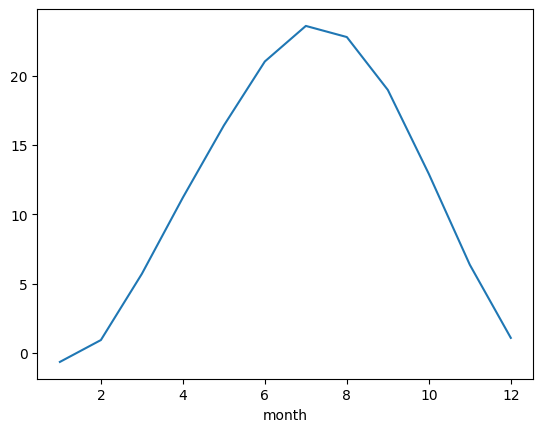

In [54]:
state_month.groupby("month")["avg_temp"].mean().plot()

# Saving Dataset

In [57]:
state_month.to_parquet("data/processed/weather_state_month.parquet", index=False)